*Unit 4, Sprint 1, Module 2*

---

# Vector Representations



As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. 

[BBC data set](http://mlg.ucd.ie/datasets/bbc.html)<br>
For today's exercise, we have downloaded the "raw text files" from the "BBC" data set and focused on the tech articles only

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

### Let's start with an analogy

![](https://peterbeshai.com/static/d9c3868cc1becd7648da453597a5d616/36dbb/DER_cube.jpg)

Pretend that the objecting floating in the room is our raw text dataset (i.e. a collection of documents). 

A vectorizer is a mathematical transformation that takes our raw text data and transforms it into a numerical representation (i.e. numbers inside of vectors). 

Depending on which vectorizer you use, you will be capturing some of the information encoded in the text but not other information. 

So, as the analogy goes, depending which side of the floating object you stand and shine a light from, you will only see a portion of the information that exists in your text data set. Apply one vectorizer and you'll get word counts but not the contextual meaning; apply another vectorizer and you'll get the contextual meaning of the words but not the counts. 

**Take Away:** Understand the benefits and limitations of using each of the vectorizers that we'll be learning today. 

----

# 0. Colab notebook setup

##0.1 Get `spacy`

In [ ]:
%%time
# You'll use en_core_web_sm for the sprint challenge due memory constraints on Codegrader
#!python -m spacy download en_core_web_sm 

# Locally (or on colab) let's use en_core_web_lg
!pip install --upgrade spacy
!python -m spacy download en_core_web_lg # Can do lg, takes awhile
# Also on Colab, need to restart runtime after this step!
#      or else Colab won't find spacy

##0.2 Restart the runtime!

## 0.3 Imports

In [1]:
""" Import Statements """

# Classics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [2]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1693, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1693 (delta 89), reused 124 (delta 72), pack-reused 1531
Receiving objects: 100% (1693/1693), 59.40 MiB | 20.43 MiB/s, done.
Resolving deltas: 100% (258/258), done.


## 0.5 Get the BBC tech articles data

Helper function to read articles in `.txt` files in a specified directory and gather them into a big list

In [3]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for filename in files: 
        
        path = os.path.join(filefolder, filename)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

Read the articles into a list

In [4]:
# locate and get path to the /data folder, using colab's file browser
data_path = '/content/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data'
data = gather_data(data_path)
print(f'Number of Articles: {len(data)}')

Number of Articles: 401


Articles turn out to be "byte strings" so we need to decode them to strings

In [5]:
print(data[20])
print(type(data[20]))

b'Gadgets galore on show at fair\n\nThe 2005 Consumer Electronics Show in Las Vegas is a geek\'s paradise with more than 50,000 new gadgets and technologies launched during the four-day event.\n\nTop gadgets at the show are highlighted in the Innovations Showcase, which recognises some of the hottest developments in consumer electronics. The BBC News website took an early pre-show look at some of those technologies that will be making their debut in 2005. \n\n \n\nOne of the key issues for keen gadget users is how to store all their digital images, audio and video files. The 2.5GB and 5GB circular pocket hard drive from Seagate might help. The external USB drive won a CES best innovations design and engineering award and is small enough to slip into a pocket. "It is the kind of storage that appeals to people who want their PCs to look cool," said Seagate. "It is all about style but it also has lots of functionality." "It is the first time you can say a hard drive is sexy," it said. In 

In [6]:
# decode bytestrings in a corpus to strings
# takes a list of documents, i.e a list of strings as input
articles = []
for article in data:
  article = article.decode("utf-8")
  articles.append(article)
print(len(articles))

# Preview first article and check data type again
data = articles
print(data[0])
print(type(data[0]))

401
New delay hits EU software laws

A fresh delay has hit controversial new European Union rules which govern computer-based inventions.

The draft law was not adopted by EU ministers as planned at a Brussels meeting on Monday during which it was supposed to have been discussed. The fresh delay came after Polish officials had raised concerns about the law for the second time in two months. Critics say the law would favour large companies over small ones and could impact open-source software innovation. "There was at one point the intention to put the item on today's agenda. But in the end we could not put it on," an EU spokesman told the Reuters agency. He added that no date had been chosen for more discussion of the law.

In December, Poland requested more time to consider the issue because it was concerned that the law could lead to the patenting of pure computer software. Its ministers want to see the phrasing of the text of the Directive on the Patentability of Computer-Implemente

Make a `spacy` tokenizer, as in Module 1<br>
Question: why did we use [`.strip()`](https://python-reference.readthedocs.io/en/latest/docs/str/strip.html)?

In [20]:
def tokenize(document):
    """
    Takes a doc (text string) and returns a list of tokens in the form of lemmas.
    Filters out Stop words, punctuation, and leading/trailing spaces. 
    """
    
    doc = nlp(document)
    # last "and" statement is to remove token lemmas that are empty strings
    lemma_list = [token.lemma_.lower().strip() for token in doc if (not token.is_stop) 
                                                                and (not token.is_punct ) 
                                                                and (token.lemma_.strip()!="") 
                                                                and (len(token.lemma_.strip())>1)]
    
    return lemma_list

In [21]:
# Test our tokenizer
tokenize('My 3 dogs ate my homework   assignments! It cost me $1.5 million.')

['dog', 'eat', 'homework', 'assignment', 'cost', '1.5', 'million']

In [22]:
data[20]

'Gadgets galore on show at fair\n\nThe 2005 Consumer Electronics Show in Las Vegas is a geek\'s paradise with more than 50,000 new gadgets and technologies launched during the four-day event.\n\nTop gadgets at the show are highlighted in the Innovations Showcase, which recognises some of the hottest developments in consumer electronics. The BBC News website took an early pre-show look at some of those technologies that will be making their debut in 2005. \n\n \n\nOne of the key issues for keen gadget users is how to store all their digital images, audio and video files. The 2.5GB and 5GB circular pocket hard drive from Seagate might help. The external USB drive won a CES best innovations design and engineering award and is small enough to slip into a pocket. "It is the kind of storage that appeals to people who want their PCs to look cool," said Seagate. "It is all about style but it also has lots of functionality." "It is the first time you can say a hard drive is sexy," it said. In t

In [23]:
tokenize(data[20])

['gadget',
 'galore',
 'fair',
 '2005',
 'consumer',
 'electronics',
 'las',
 'vegas',
 'geek',
 'paradise',
 '50,000',
 'new',
 'gadget',
 'technology',
 'launch',
 'day',
 'event',
 'gadget',
 'highlight',
 'innovations',
 'showcase',
 'recognise',
 'hot',
 'development',
 'consumer',
 'electronic',
 'bbc',
 'news',
 'website',
 'take',
 'early',
 'pre',
 'look',
 'technology',
 'make',
 'debut',
 '2005',
 'key',
 'issue',
 'keen',
 'gadget',
 'user',
 'store',
 'digital',
 'image',
 'audio',
 'video',
 'file',
 '2.5',
 'gb',
 'gb',
 'circular',
 'pocket',
 'hard',
 'drive',
 'seagate',
 'help',
 'external',
 'usb',
 'drive',
 'win',
 'ces',
 'good',
 'innovation',
 'design',
 'engineering',
 'award',
 'small',
 'slip',
 'pocket',
 'kind',
 'storage',
 'appeal',
 'people',
 'want',
 'pc',
 'look',
 'cool',
 'say',
 'seagate',
 'style',
 'lot',
 'functionality',
 'time',
 'hard',
 'drive',
 'sexy',
 'say',
 'centre',
 'device',
 'blue',
 'light',
 'flash',
 'datum',
 'write',
 'ensure

# 1. Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). <br>
In the DTM, each row represents a document. The columns correspond to the vocabulary words of the entire corpus of documents. <br>
Today, we'll learn three methods of computing the value in each cell. <br>
* `CountVectorizer` from `sklearn` provides a basic implementation: counts of appearances of words. You could also ignore multiple occurrences of words in a document, and just keep track of whether or not a word occurs in the document via a boolean value.<br>
* `TfidfVectorizer` is a more advanced implementation that keeps track of *term-frequency inverse-document frequency* (TF-IDF) instead of integer counts.

* Word embeddings, an even more sophisticated method that helps solve the problem of accounting for the context of a word.

**Discussion:** Don't we lose all the context and grammar if we do this? So Why does it work?

## Follow Along

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [24]:
text = """
GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of unprecedented quality, 
where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 outperforms other language models 
trained on specific domains (like Wikipedia, news, or books) without needing to use these domain-specific training datasets. On language 
tasks like question answering, reading comprehension, summarization, and translation, GPT-2 begins to learn these tasks from the raw text, 
using no task-specific training data. While scores on these downstream tasks are far from state-of-the-art, they suggest that the tasks 
can benefit from unsupervised techniques, given sufficient (unlabeled) data and compute."""

print(f'Number of Words: {len(text.split())}')

Number of Words: 110


In [25]:
tokens = tokenize(text)
print(f'Number of Words: {len(tokens)}')
tokens

Number of Words: 73


['gpt-2',
 'display',
 'broad',
 'set',
 'capability',
 'include',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'sample',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'gpt-2',
 'outperform',
 'language',
 'model',
 'train',
 'specific',
 'domain',
 'like',
 'wikipedia',
 'news',
 'book',
 'need',
 'use',
 'domain',
 'specific',
 'training',
 'dataset',
 'language',
 'task',
 'like',
 'question',
 'answering',
 'read',
 'comprehension',
 'summarization',
 'translation',
 'gpt-2',
 'begin',
 'learn',
 'task',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'datum',
 'score',
 'downstream',
 'task',
 'far',
 'state',
 'art',
 'suggest',
 'task',
 'benefit',
 'unsupervised',
 'technique',
 'give',
 'sufficient',
 'unlabeled',
 'datum',
 'compute']

-----
# 1.1 `CountVectorizer`

![](https://images4.programmersought.com/947/0a/0acb9279d17a1631bcfb154583cca443.JPEG)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer


# list of text documents

# create the transformer

# build vocab

# transform text

### BEGIN SOLUTION
# a corpus is a collection of text documents
corpus = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
          " In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
          " This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vectorizer = CountVectorizer()

# build vocabulary
vectorizer.fit(corpus) #this model's vocab will be the set of words on what was fit

# transform text to create the document-term matrix
dtm = vectorizer.transform(corpus)
dtm #sparse matrix representation is a notation that ignores the 0s in the matrix (because it is sparse)


### END SOLUTION

<3x61 sparse matrix of type '<class 'numpy.int64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [28]:
# explore the document-term matrix 

# Get feature names
print(vectorizer.get_feature_names_out()) #this is the set of words of our doc
print(len(vectorizer.get_feature_names_out()))

# Dealing with Sparse Matrix
print(dtm.todense())

# Get Word Counts for each document
df_dtm = pd.DataFrame(dtm.todense(), columns=vectorizer.get_feature_names_out())
print(df_dtm.shape)
df_dtm.head()





['as' 'at' 'be' 'been' 'by' 'can' 'commoncrawl' 'content' 'created'
 'curated' 'data' 'dataset' 'datasets' 'diversity' 'document'
 'educational' 'emphasizes' 'filtered' 'for' 'found' 'from' 'funny' 'have'
 'heuristic' 'higher' 'humans' 'in' 'indicator' 'interesting' 'internet'
 'karma' 'leading' 'least' 'link' 'links' 'new' 'of' 'only' 'or' 'order'
 'other' 'outbound' 'pages' 'preserve' 'quality' 'received' 'reddit'
 'scraping' 'similar' 'specifically' 'such' 'than' 'the' 'this' 'thought'
 'to' 'used' 'users' 'we' 'whether' 'which']
61
[[0 0 0 0 1 0 0 2 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
  1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1]
 [0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0
  0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 2 0 2 0 2]
 [2 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0
  1 0 1 0 2 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 2 0]]
(3, 61)


,as,at,be,been,by,can,commoncrawl,content,created,curated,...,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,...,0,1,0,0,0,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,2,0,2,0,2
2,2,0,1,0,0,1,1,0,0,0,...,1,1,1,1,1,0,1,0,2,0


In [ ]:
dtm_new

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [31]:
type(data)

list

In [34]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer

# Learn our Vocab
# Get sparse dtm (i.e. transform the data)

### BEGIN SOLUTION
vect = CountVectorizer().fit(data)
dtm_bbc = vect.transform(data)

df_dtm_bbc = pd.DataFrame(data=dtm_bbc.todense(), columns=vect.get_feature_names_out())

print(df_dtm_bbc.shape)
df_dtm_bbc.head()


(401, 12098)


,00,000,000s,0051,007,01,028,04m,05,0530,...,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


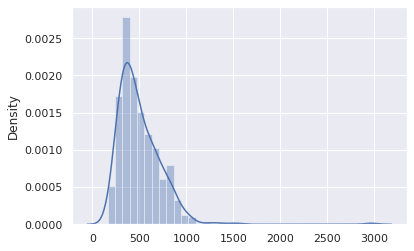

In [39]:
import seaborn as sns
# sns.set() #alias for set_theme...

doc_len = [len(doc.split()) for doc in data]
sns.distplot(doc_len);

#1.2  `TfidfVectorizer`

## Term Frequency - Inverse Document Frequency (TF-IDF)

![](https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg)


**Term Frequency**: $\text{tf}_{i,j}$  is the number of times term $i$ appeared in document $j$ 

**Inverse Document Frequency:** A weight penalty for terms that exist in a high fraction of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents. This effectively upweights terms that are rarer across documents.


#1.2  `TfidfVectorizer`

## Term Frequency - Inverse Document Frequency (TF-IDF)

![](https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg)


**Term Frequency**: $\text{tf}_{i,j}$  is the number of times term $i$ appeared in document $j$ 

**Inverse Document Frequency:** A weight penalty for terms that exist in a high fraction of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents. This effectively upweights terms that are rarer across documents.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/81/Logarithm_plots.png" width="700" height="400" />

It's useful to reference both the algebraic and geometric representations of a single mathematical ideal whenever possible in order to build the fullest understanding possible. 

The IDF portion of the TF-IDF equation has been coded up below so that we can play around with the values and get a better understanding of how this portion of the equation works. 

NOTE: There are other ways to construct the equation for the IDF term; different constructions of the equation serve different purposes and which you ultimately use simply depends on your problem/task. You can check out the [wikipedia article on tfidf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In practice, you usually don't even have to think about the mathematical formulation of the IDF term. You simply import the tfidf vectorizer and use its api. The rare exception to this would if you are working a very particular kind of problem where the open source implementation of tfidf doesn't suit your needs and so then you might consider creating your own equation or using a different one that you read about. 

In [40]:
# inverse document frequency score 
# the plus ones are constants that shift the around the baseline value 
def idf(n, df):
    """
    Parameters
    ----------
    n: int
        num of docs in corpus 
        
    df: int
        num of docs that term t (i.e. a token) appears in 

    Returns
    -------
    inverse docuemnt frequency: float
    """
    return np.log( n/ df) # this uses natural log!

In [41]:
n = 100                 # num of docs in corpus 
df_range = 100
IDF = []
DF = []
for df in range(1, df_range + 1):
    idf_score = idf(n, df)
    IDF.append(idf_score)
    DF.append(df)

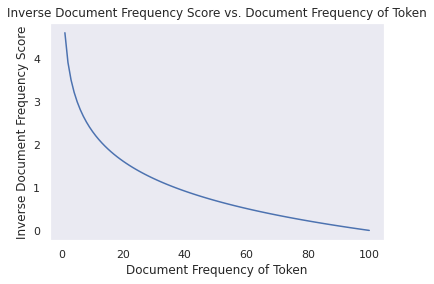

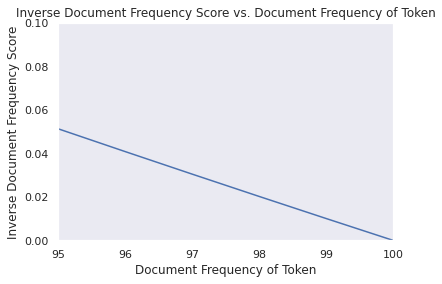

In [42]:
plt.figure()
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.grid()
plt.plot(DF, IDF);
plt.show()


# Term Frequency of 100%: log(1) = 0
plt.figure()
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.xlim(95,100)
plt.ylim(0,0.10)
plt.grid()
plt.plot(DF, IDF);
plt.show()

In [49]:
# let's work through a couple of examples to help build intuition 
# imagine the token we are considering is "purchase", which rarely appears
# imagine the token that we are considering is "the", which appears often

n = 100

# imagine the token we are considering is "purchase"
tf = 1
df = 20

tfidf_score = tf * idf(n, df)
print(f'purchase: {tfidf_score:.2f}')

# imagine the token that we are considering is "the"
tf = 50
df = 95

tfidf_score = tf * idf(n, df)
print(f'the: {tfidf_score:.2f}')

purchase: 1.61
the: 2.56


Now that we have built some intuition on how TFIDF works, let's use `sklearn`'s `TfidfVectorizer` to vectorize our dataset. <br>
Note that `TfidfVectorizer` is used with the same syntax as `CountVectorizer`

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
  # try using stop words from spaCy

# 2. Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data)

# 3. View term-document matrix as DataFrame
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out())
print(dtm.shape)
dtm.head()

(401, 1000)


,000,10,100,11,12,14,15,18,20,200,...,worldwide,worm,worth,writing,xbox,xp,yahoo,year,years,york
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.048098,0.0
1,0.034932,0.040224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061562,0.0,0.0,0.0,0.0,0.0,0.000000,0.057273,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.654931,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.027212,0.0
4,0.039221,0.090325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.064305,0.000000,0.0


Now let's get a little fancier with the `TfidfVEctorizer`: we'll use the keywords `ngram_range`, `max_df`, `min_df` and `tokenizer` to accomplish the following:
- Build a vocabulary from unigrams and bigrams
- Do "statistical trimming" by ignoring all terms with document frequency higher than `max_df` and all terms with document frequency lower than `min_df`
- Use the `spaCy` tokenizer that we built 

In [51]:
%%time
### BEGIN SOLUTION
# Instantiate vectorizer object (ngram_range includes unigrams and bigrams)
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        max_df=0.25,            # "statistical trimming"
                        min_df=5,               # "statistical trimming"
                        tokenizer=tokenize)     # custom tokenizer

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out())
print(dtm.shape)

# View Feature Matrix as DataFrame

### END SOLUTION

(401, 3549)
CPU times: user 42.9 s, sys: 54.5 ms, total: 42.9 s
Wall time: 46.2 s


In [52]:
dtm.head()

,"1,000",1.3,1.5,1.5 million,10,10 million,10 time,10 year,"10,000",100,...,year time,yen,yes,york,young,young people,youth,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.035442,0.067225,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.068968,0.065408,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# 2. Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works in Google? You may just think that search bars simply match your input text against the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply two measures of similarity between a document and the input query document: the **Cosine Similarity** between the documents and the **Euclidean distance** between the documents. <br>

Cosine Similarity is [more compute intensive](https://stackoverflow.com/questions/28917985/why-cosine-distance-is-much-slower-than-using-euclidean-distance-with-dbscan-alg) than Euclidean distance.

## Follow Along
*Cosine similarity* and *nearest-neighbor distance* provide two measures that can be used to gauge the similarity of one word to another. <br>
We develop these concepts in this section.

### 2.1 Cosine Similarity
The [`cosine_simlarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) between two feature vectors is the dot product of the *normalized* feature vectors. <br>To *normalize* a vector, you simply divide it by its length: thus<br><br>
$\text{cosine_similarity}(\textbf{u},\textbf{v})= \frac{\textbf{u}}{\left\|\textbf{u}\right\|} \cdot \frac{\textbf{v}}{\left\|\textbf{v}\right\|}$, <br><br>
where $\left\|\textbf{u}\right\|$ is the length of the vector $\textbf{u}$<br><br>

$\textbf{cosine_similarity}$ is in the interval $[0, 1]$, <br><br>
The larger the $\textbf{cosine_similarity}$, the more similar the words are, and vice-versa.<br><br>

`cosine_similarity` takes as input the document-term matrix <br>
and creates a **similarity matrix** in which the rows and columns represent documents <br>
and entry ($i, j$) is the cosine similarity between documents $i$ and $j$.<br><br>

Let's compute the **similarity matrix** for the BBC tech articles corpus<br>



In [53]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Distance of TF-IDF Vectors

# Turn it into a DataFrame

# Our Similarity Matrix is ? size 

# Each row is the similarity of one document to all other documents (including itself)

# Grab the row and pick off the indicies of the most/least similar docs

# Calculate Distance of TF-IDF Vectors
from sklearn.metrics.pairwise import cosine_similarity

# similarity matrix
dist_matrix = cosine_similarity(dtm)

# Turn it into a DataFrame
df = pd.DataFrame(dist_matrix)

# Size of the Similarity Matrix 
print(df.shape)

(401, 401)
CPU times: user 55.1 ms, sys: 24.7 ms, total: 79.8 ms
Wall time: 65.9 ms


In [54]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.024167,0.014161,0.015564,0.009947,0.010028,0.003200,0.009225,0.007811,0.024582,...,0.012303,0.013175,0.001381,0.009216,0.021193,0.012833,0.025224,0.016521,0.036601,0.012644
1,0.024167,1.000000,0.032979,0.056788,0.028829,0.061492,0.027166,0.009739,0.014174,0.031265,...,0.002990,0.055416,0.038204,0.009319,0.027300,0.036228,0.321214,0.049168,0.018659,0.111530
2,0.014161,0.032979,1.000000,0.067698,0.012676,0.019885,0.066610,0.023622,0.059834,0.031792,...,0.036122,0.016941,0.023554,0.032119,0.040907,0.030927,0.005265,0.013400,0.003509,0.017196
3,0.015564,0.056788,0.067698,1.000000,0.026972,0.046360,0.047284,0.008035,0.014080,0.040100,...,0.082199,0.029362,0.058474,0.013291,0.141601,0.037376,0.030711,0.035686,0.030135,0.035682
4,0.009947,0.028829,0.012676,0.026972,1.000000,0.002555,0.017061,0.006022,0.001563,0.083719,...,0.022007,0.400820,0.001948,0.016769,0.026052,0.038574,0.043754,0.046452,0.036439,0.032712


In [60]:
# Each row is the similarity of one document to all other documents (including itself)


0.7291921901229127

### Find the most similar documents to the first document

In [66]:
### BEGIN SOLUTION
# Grab the first row and return the indices of the 5 most similar docs
df.iloc[0][1:].sort_values(ascending=False).head(5)
### END SOLUTION

227    0.729192
338    0.657955
131    0.505425
37     0.505425
139    0.313778
Name: 0, dtype: float64

In [71]:
# 1st and 228th document
# Both articles are about EU software legislation and Poland!

print(data[0])
print("---------------------")
print(data[227])

New delay hits EU software laws

A fresh delay has hit controversial new European Union rules which govern computer-based inventions.

The draft law was not adopted by EU ministers as planned at a Brussels meeting on Monday during which it was supposed to have been discussed. The fresh delay came after Polish officials had raised concerns about the law for the second time in two months. Critics say the law would favour large companies over small ones and could impact open-source software innovation. "There was at one point the intention to put the item on today's agenda. But in the end we could not put it on," an EU spokesman told the Reuters agency. He added that no date had been chosen for more discussion of the law.

In December, Poland requested more time to consider the issue because it was concerned that the law could lead to the patenting of pure computer software. Its ministers want to see the phrasing of the text of the Directive on the Patentability of Computer-Implemented In

### 2.2 K Nearest Neighbors Search (kNN) 

<img src="https://miro.medium.com/max/753/0*jqxx3-dJqFjXD6FA" width="600" height="400" />


Nearest Neighbor models are distance based algorithms. They store your training set in memory. 

### `scikit-learn`'s `NearestNeighbors` class 
computes distances between all pairs of data points, <br>
and returns the result in the form of a similarity matrix. <br>
Entry $(i,j)$ in the similarity matrix records the similarity of data points $i$ and $j$.<br>

Below is an example using `NearestNeighbors` to find the most similar documents to a given documentL


In [72]:
%%time
from sklearn.neighbors import NearestNeighbors

# Instantiate the nearest neighbors model
nn = NearestNeighbors()

# fit to our document term matrix
nn.fit(dtm.values)

CPU times: user 8.58 ms, sys: 0 ns, total: 8.58 ms
Wall time: 13.6 ms


NearestNeighbors()

Find the 5 most similar documents to a query document; here we will choose the first document as our query document

In [81]:
# sample a doc from a dtm to use as our query point
doc_index = 0
query_doc = dtm.values[0][None,:] # re-cast as a row vector same as [[]]

# Query Using the kneighbors method
# NOTE: nn counts the original document as one of the neighbors, so if we want 5 nearest neighbors, we should set n_neightbors=6
neigh_dist, neigh_index = nn.kneighbors(query_doc,n_neighbors=6)

In [82]:
# nearest neighbor search returns the same documents as cosine similarity!
print(neigh_index)
print(neigh_dist)

[[  0 227 338 131  37 382]]
[[2.98023224e-08 7.35945392e-01 8.27097209e-01 9.94560133e-01
  9.94560133e-01 1.17151368e+00]]


In [83]:
data[0]

'New delay hits EU software laws\n\nA fresh delay has hit controversial new European Union rules which govern computer-based inventions.\n\nThe draft law was not adopted by EU ministers as planned at a Brussels meeting on Monday during which it was supposed to have been discussed. The fresh delay came after Polish officials had raised concerns about the law for the second time in two months. Critics say the law would favour large companies over small ones and could impact open-source software innovation. "There was at one point the intention to put the item on today\'s agenda. But in the end we could not put it on," an EU spokesman told the Reuters agency. He added that no date had been chosen for more discussion of the law.\n\nIn December, Poland requested more time to consider the issue because it was concerned that the law could lead to the patenting of pure computer software. Its ministers want to see the phrasing of the text of the Directive on the Patentability of Computer-Implem

In [84]:
data[227]

'EU software patent law delayed\n\nControversial new EU rules for the patenting of computer-based inventions have been put on hold due to a last minute intervention from Poland.\n\nPoland - a large and therefore crucial EU member - has requested more time to consider the issue, especially as it relates to the patenting of software. Critics say the law would favour large companies over small, innovative ones. They say it could have massive ramifications for developments such as open source software.\n\nPolish ministers want to see the phrasing of the text of the Directive on the Patentability of Computer-Implemented Inventions changed so that it excludes the patenting of software. The planned law has ignited angry debate about whether the EU should allow the patenting of computer programs and internet business methods as currently happens in the US. So, for instance, US-based Amazon.com holds a patent on \'one-click shopping\'. Critics claim the law, which the EU says is needed to harmo

Which words do these two documents have in common?

> Indented block



In [ ]:
def shared_words(s1, s2):
  res = []
  l_s1, l_s2 = set(s1.split()), set(s2.split())
  for ss1 in l_s1:
    if ss1 in l_s2: res.append(ss1)
  return res

doc1_tokens = tokenize(data[0])
doc2_tokens = tokenize(data[227])
shared_words(' '.join(doc1_tokens), ' '.join(doc2_tokens))

### Exercise: 
Search the BBC dataset for documents most similar to a random query doc

In [88]:
rndm_tech_article = [ """
Blockchain technology encompasses so much more than just cryptocurrencies these days. And while these currencies are by far blockchain’s most famous use case, the potential for blockchain far, far exceeds a straightforward transfer of value.
The gaming industry, for example, has always been fairly controversial due to a range of issues. Many players feel particularly worried about the protection of their data, fraudulent activities, high fees, and most of all, unfair and hidden odds.
In these cases, P2P doesn’t just mean peer-to-peer; it means player-to-player. As with the other P2P industries that blockchain is disrupting, such as FinTech, there are already plenty of ways in which blockchain technology is being applied to resolve these issues and many more of the challenges faced by the gaming industry. Here are just a few.
Reducing fraud
The gaming industry suffers a lot from online fraud. One of the main advantages of blockchain technology is that it enables highly secure data encryption. What’s more, all of it is entirely accessible and transparent to the player. In other words, blockchain is a for game changer for venues such as online casinos, lotteries, and virtually anything which relies on random number generation.
On top of this, hackers will have particularly hard time, if it is even possible, to destroy a decentralized blockchain network, making sure gamer data stays safe. This is an inherent feature of distributed ledger technology whereby nodes in the ledger maintain the distributed databases in a shared manner, and each node has the complete information in the entire database.
"""]


# transform the rndm_tech_article to get its document vector
doc_tfidf = tfidf.transform(rndm_tech_article)
doc_tfidf

<1x3549 sparse matrix of type '<class 'numpy.float64'>'
	with 61 stored elements in Compressed Sparse Row format>

In [89]:
# use k Nearest Neighbors to find the most similar documents in our document term matrix to the query
neigh_dist, neigh_index = nn.kneighbors(doc_tfidf, n_neighbors=10)

In [90]:
# Inspect the most similar documents 
print(neigh_dist, neigh_index)

[[1.28274362 1.28285451 1.29550261 1.30942299 1.31330908 1.31716547
  1.31817308 1.31848061 1.31848061 1.3238883 ]] [[129  46 316 377 399  58 312  49 171  45]]


In [92]:
# Document @ 129:
print(data[129])
# Document @ 46
print(data[46])

#Shared words:
print(shared_words(data[129], data[46]))

Peer-to-peer nets 'here to stay'

Peer-to-peer (P2P) networks are here to stay, and are on the verge of being exploited by commercial media firms, says a panel of industry experts.

Once several high-profile legal cases against file-sharers are resolved this year, firms will be very keen to try and make money from P2P technology. The expert panel probed the future of P2P at the Consumer Electronics Show in Las Vegas earlier in January. The first convictions for P2P piracy were handed out in the US in January. William Trowbridge and Michael Chicoine pleaded guilty to charges that they infringed copyright by illegally sharing music, movies and software. Since the first successful file-sharing network Napster was forced to close down, the entertainment industry has been nervous and critical of P2P technology, blaming it for falling sales and piracy. But that is going to change very soon, according to the panel.

The music and film industries have started some big legal cases against owner

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# 3. Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>


## Overview
### Bag of Words (BoW) models lose information about context

One of the limitations of Bag-of-Words approaches is that any information about the context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

##3.1 Word2Vec Intuition
Reference: [Deep NLP: Word Vectors with Word2Vec](https://medium.com/deep-learning-demystified/deep-nlp-word-vectors-with-word2vec-d62cb29b40b3)
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the [Distribution Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics). The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the rainiest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "rainiest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_rainiest | rainiest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| rainiest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_rainiest | rainiest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| rainiest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and rainiest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have relatd meanings because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

##3.2 Word2Vec Variants

###3.2.1 Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

###3.2.2 Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Porsche”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

###3.2.3 Notes on Word Embeddings:

1) Word2Vec is useful for topic-modeling, because each word vector contains information about related context words.

2) Word2Vec can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings to do really cool things! 
Let's take a look at how to work with these word vectors.

## 3.3 Spacy word embeddings
#### `spacy` provides pretrained Word2Vec models. 

We will use their `en_core_web_md` model, which has 300-dimensional word embeddings for 20,000 words. 

In [96]:
# Process a text
doc = nlp("bananas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector

# print the dimensionality of the vector embedding
print(len(bananas_vector))
print(bananas_vector)

300
[-2.1689e-01 -2.5989e+00 -1.3144e+00  2.2500e+00 -4.6767e-01 -2.0695e+00
 -6.3379e-01 -4.0222e-01 -3.4022e+00 -3.6932e-01 -7.9938e-01 -1.0412e+00
  9.3756e-01  1.6070e+00  8.8330e-01 -2.8483e+00  1.3349e-01 -3.1656e+00
  8.1896e-01 -4.8113e+00  1.5655e+00  1.6665e+00 -4.7081e-01 -1.9475e+00
 -1.1779e+00 -1.3810e+00 -2.0071e+00 -2.1639e-01  9.0609e-01  1.5279e+00
  1.2587e-04 -2.9000e+00  7.6069e-01 -2.2825e+00  1.2495e-02 -1.5653e+00
  2.0052e+00 -1.7747e+00  5.9220e-01 -1.1428e+00 -1.3441e+00  3.4784e-01
  1.7492e+00  1.9086e+00  1.0600e+00  1.2965e+00  4.1431e-01  7.9416e-01
 -1.1277e+00 -1.1403e+00  7.5891e-01 -9.4419e-01  1.4413e+00 -2.2554e+00
  1.6226e-01  3.8901e-01  1.2299e-01  1.1577e+00  1.5524e+00  1.3853e+00
  1.1112e+00  7.5767e-01  3.9431e+00 -2.8506e-01 -2.1645e+00 -1.0862e+00
 -1.4973e+00 -1.2781e+00  2.4643e+00 -1.5886e+00  2.5679e-01  6.4918e-01
  1.6809e-01  5.7693e-01  3.1121e-01 -4.5278e-01 -2.7555e+00 -2.1846e+00
  4.4865e+00  2.7107e-01 -5.3831e-01  8.3013e-0

In [97]:
apple = nlp('apple')
banana = nlp('banana')
gravity = nlp('gravity')

print(f'Apple -> Banana similarity: {apple.similarity(banana)}')
print(f'Apple -> Gravity similarity: {apple.similarity(gravity)}')
print(f'Banana -> Gravity similarity: {banana.similarity(gravity)}')

Apple -> Banana similarity: 0.6646700384869841
Apple -> Gravity similarity: 0.1950858162480275
Banana -> Gravity similarity: 0.07896224402806362


### Spacy Document vectors

From spacy we can get word2vec embeddings for each word in a document<br>
We can create a document vector by averaging all the word vectors in that doc<br>
We can calculate the similarity between documents now! 

In [98]:
doc1 = nlp("On a hot summer day, it's good to drink water.")
doc2 = nlp("There are lots of cold drinks in the refrigerator.")
doc3 = nlp("cosine distance measures similarity")

In [99]:
len(doc1.vector)

300

In [100]:
type(doc)

spacy.tokens.doc.Doc

In [101]:
# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.6108931607606939


In [102]:
doc3.similarity(doc2)

0.5440013341813931

In [103]:
doc3.similarity(doc1)

0.4692416983237825

## Challenge: can we make a "thesaurus"?<br>
Given a query word, do you think we could find good synonyms  <br>
by doing a nearest neighbor search on the `spacy` word embeddings?<br>
Let's give it a try!

First, get the embeddings for the vocabulary words and make a document-term matrix

In [104]:
%%time
vocab = list(nlp.vocab.strings)
print(len(vocab))

777060
CPU times: user 275 ms, sys: 25.3 ms, total: 301 ms
Wall time: 301 ms


In [106]:
# eliminate duplicates due to mixing upper and lower case
vocab =[word.lower() for word in vocab]
vocab = list(set(vocab))
print(len(vocab))

428089


In [107]:
%%time
word_vectors = [nlp.vocab.get_vector(word) for word in vocab]
word_vectors = np.asarray(word_vectors)
print(word_vectors.shape)

(428089, 300)
CPU times: user 1.7 s, sys: 684 ms, total: 2.39 s
Wall time: 2.4 s


Fit a nearest-neighbors model to the document-term matrix

In [108]:
%%time
nn = NearestNeighbors(n_neighbors=20, algorithm='auto')

# fit to the document-term matrix of all the vocabulary words
nn.fit(word_vectors)

CPU times: user 177 ms, sys: 1.46 ms, total: 179 ms
Wall time: 204 ms


NearestNeighbors(n_neighbors=20)

Choose a query word, for which you want to find synonyms

In [122]:
query_word = 'marvelous'
query_vector = nlp.vocab.get_vector(query_word).reshape(1,-1)
query_vector.shape

(1, 300)

Find the nearest neighbors to the query, from spacy's vocabulary

In [126]:
neigh_dist, neigh_index = nn.kneighbors(query_vector, n_neighbors=5)
[vocab[int(index)] for index in neigh_index[0]]

['marvelous', 'marvellous', 'splendid', 'fantabulous', 'stupendous']

## Can we visualize word vectors?

300 dimensional word vectors are difficult (impossible) to visualize! <br>
However, we can use Principal Components Analysis (PCA) to reduce their dimensionality. <br>

PCA is one of the most important techniques in machine learning, and indeed in all of mathematics! PCA transforms the feature vectors of a data set to their "Principal Components", which are ranked in order of their importance in describing the data set. By eliminating the less important Principal Components, we can reduce the dimensionality of the data set, at the cost of losing some information.

If you're interested to explore this topic in greater depth, here are a couple of references:
- One of the best brief introductions to the mathematics of PCA is [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en)
- For a more in-depth, but still understandable exposition of PCA, watch the Statquest video [Principal Component Analysis (PCA), Step-by-Step](https://youtu.be/FgakZw6K1QQ) from Josh Starmer.

Now let's use PCA to reduce our 300-dimensional word vectors down to two dimensions, so that we can visualize them in a plane. Of course, in the process we lose a lot of information, but these 2D word vectors still pack a surprising amount of information!

In [131]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['machine learning', 'man', 'woman',  'king', 'queen',
         'artificial intelligence', 'nurse', 'doctor', 
         'data', 'science', 'concrete', 'wood',  'marble', 
         'design', 'color', 'font', 'pharmacy', 'medicine', 'vancomycin', 'bacteria', 'infection']


word_vectors = get_word_vectors(words)

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(word_vectors)

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(word_vectors)

# let's look at our new 2D word vectors
word_vecs_2d

array([[ 11.26649978,  -0.80079459],
       [-46.70616148, -10.36564896],
       [-35.61520098, -11.89800433],
       [-20.28485113,  -3.72986109],
       [-25.08973905,   0.3928278 ],
       [ 10.2344484 ,  -5.29759403],
       [-16.87124951, -19.9138406 ],
       [-15.28269793, -20.77570408],
       [ 66.29253484, -28.04614402],
       [ 14.00629983, -14.51714492],
       [  7.42847034,  15.46051316],
       [  0.45345633,  46.85514645],
       [ -6.39501644,  27.05285396],
       [ 20.47422842,  18.39230087],
       [  8.23808426,  26.69900165],
       [  6.7742669 ,  24.71752388],
       [  1.52456236, -12.12881707],
       [  2.03121054, -14.28699612],
       [ -2.68979929,  -2.51160955],
       [  7.61593371,  -1.0095694 ],
       [ 12.59472008, -14.28843899]])

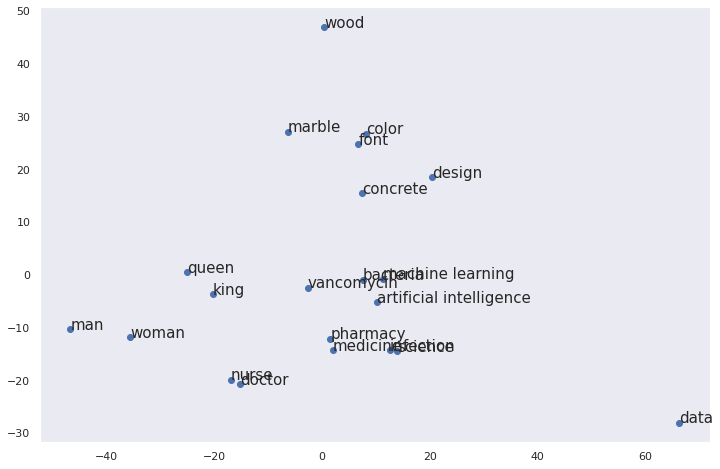

In [132]:
# create a nice big plot 
plt.figure(figsize=(12,8))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.grid();
plt.show()

### Spend a few minutes exploring the magic of word vectors!
Create your own `words` list and run it through the code in the above two cells. <br>
Perhaps include clusters of words that have similar meanings or that might <br>reveal implicit gender bias or some other kind of bias. What did you find out?

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

## King - Man + Woman = Queen 

Check out [**The amazing power of word vectors**](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/), which explores the above equation

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf